In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.model_selection._search import ParameterGrid

In [2]:
import copy
from functools import partial

In [3]:
%matplotlib inline

# Introduction to Monte-Carlo Simulation with Python


https://amypeniston.com/ditching-excel-for-python/

https://quantecon.org/python-lectures/ - tons of great example notebook. Done by top economists (Sargent). Mix of OO and non-OO just based on what makes the most sense. No need to be dogmatic.

Journal of Open Source Education - https://jose.theoj.org/

## Monte-carlo simulation
In the Excel world, we might use add-ins such as @Risk which allow uncertain quantities to be directly modeled with probability distributions. For example, a financial model might have a key input such as future sales that is highly uncertain. By modeling future sales with a probability distribution and then sampling from that distribution many times (essentially by recalcing the spreadsheet) we can generate a bunch of possible values for key outputs (e.g. profit) and use statistics to summarize these outputs using things like histograms and summary stats. Often this type of simulation model is referred to as a *Monte-Carlo* model to suggest repeated sampling from one or more probability distributions within an otherwise pretty static model. If you want to see such models in action, check out my [Simulation Modeling with Excel page](http://www.sba.oakland.edu/faculty/isken/courses/mis5460_w21/simulation.html) from my Business Analytics course.

Of course we could create such models in Python. Let's build a really simple model in which we are selling a single product that we produce. There is a fixed cost to producing the product as well as a variable production cost per unit. We can sell the product for some price at which we believe that demand for the product will be normally distributed with a certain mean and standard deviation. Let's assume for now that we have sufficient capacity to produce to demand.

In [4]:
fixed_cost = 20000
var_cost = 40
selling_price = 50
demand_mean = 10000
demand_sd = 2000

If we ignore demand uncertainty and just use the mean demand as a deterministic quantity, we'd have the following simple profit model.

In [169]:
profit_det = selling_price * demand_mean - var_cost * demand_mean - fixed_cost
print(profit_det)

-25790.0


### Bookstore model

#### Base model

In [4]:
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50

order_quantity = 200

demand_mean = 193
demand_sd = 40

demand = demand_mean

Let's also create an OO approach though it feels like it's going to be tougher to use within analysis functions like data tables and goal seek. Maybe not.

In [5]:
# OO version
class BookstoreModel():
    def __init__(self, unit_cost, selling_price, unit_refund, order_quantity, demand):
        self.unit_cost = unit_cost
        self.selling_price = selling_price
        self.unit_refund = unit_refund
        self.order_quantity = order_quantity
        self.demand = demand
        
    def update(self, param_dict):
        """
        Update parameter values
        
        https://stackoverflow.com/questions/2466191/set-attributes-from-dictionary-in-python
        """
        for key in param_dict:
            setattr(self, key, param_dict[key])
        
    def order_cost(self):
        return self.unit_cost * self.order_quantity
    
    def sales_revenue(self):
        return np.minimum(self.order_quantity, self.demand) * self.selling_price
    
    def refund_revenue(self):
        return np.maximum(0, self.order_quantity - self.demand)
    
    def profit(self):
        '''
        Compute profit in bookstore model
        '''
        profit = self.sales_revenue() + self.refund_revenue() - self.order_cost()
        return profit
    
#    def __repr__(self):
#        """
#        https://stackoverflow.com/questions/61517/python-dictionary-from-an-objects-fields
#        """
#        return vars(self)
    
    def __str__(self):
        """
        https://stackoverflow.com/questions/61517/python-dictionary-from-an-objects-fields
        """
        return str(vars(self))

In [6]:
model1 = BookstoreModel(unit_cost=unit_cost, 
                        selling_price=selling_price,
                        unit_refund=unit_refund,
                        order_quantity=order_quantity,
                        demand=demand)

https://stackoverflow.com/questions/61517/python-dictionary-from-an-objects-fields

In [95]:
# Better to use vars(model1)
model1.__dict__

{'unit_cost': 7.5,
 'selling_price': 10.0,
 'unit_refund': 2.5,
 'order_quantity': 200,
 'demand': 193}

In [71]:
print(model1)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


In [76]:
new_params = {'unit_cost': 8.5, 'order_quantity': 250}
model1.update(new_params)
print(model1)

{'unit_cost': 8.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 250, 'demand': 193}


In [72]:
model1.profit()

437.0

In [9]:
# Deterministic model
demand = demand_mean

In [10]:
order_cost = unit_cost * order_quantity
sales_revenue = min(order_quantity, demand) * selling_price
refund_revenue = max(0, order_quantity - demand)
profit = sales_revenue + refund_revenue - order_cost

In [11]:
print(profit)

437.0


# Sensitivity analysis analogous to a 1-way Data Table

- demand
- order quantity

The brute force way would be to redo model with a vector - I think that will work.

In [12]:
demand = np.arange(70, 321, 5)

In [13]:
order_cost = unit_cost * order_quantity
sales_revenue = np.minimum(order_quantity, demand) * selling_price
refund_revenue = np.maximum(0, order_quantity - demand)
profit = sales_revenue + refund_revenue - order_cost

We can't just use min with a scalar compared to a vector. Need to use numpy functions since they will do broadcasting.

In [14]:
print(profit)

[-670. -625. -580. -535. -490. -445. -400. -355. -310. -265. -220. -175.
 -130.  -85.  -40.    5.   50.   95.  140.  185.  230.  275.  320.  365.
  410.  455.  500.  500.  500.  500.  500.  500.  500.  500.  500.  500.
  500.  500.  500.  500.  500.  500.  500.  500.  500.  500.  500.  500.
  500.  500.  500.]


Can we do same with OO version?

In [28]:
# Method 1: Set property equal to an array
model1.demand = np.arange(70, 321, 5)

In [29]:
# yes, we can
model1.profit()

array([-670., -625., -580., -535., -490., -445., -400., -355., -310.,
       -265., -220., -175., -130.,  -85.,  -40.,    5.,   50.,   95.,
        140.,  185.,  230.,  275.,  320.,  365.,  410.,  455.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.])

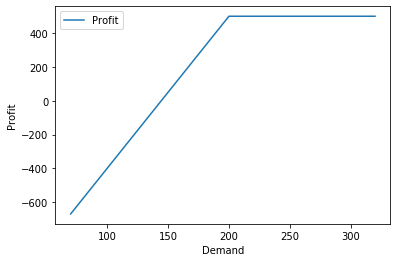

In [15]:
plt.plot(demand, profit, label="Profit")
plt.xlabel('Demand')
plt.ylabel('Profit')
plt.legend()
plt.show()

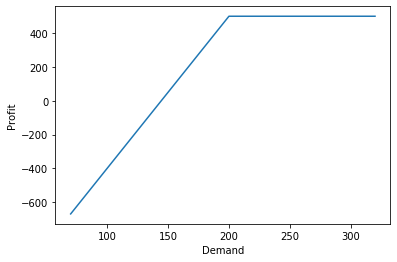

In [16]:
sns.lineplot(x=demand, y=profit)
plt.xlabel('Demand')
plt.ylabel('Profit')
plt.show()

What about a 2-way Data Table? One approach might be to create a profit function that we can call from within a list comprehension.

In [32]:
demand_range = np.arange(70, 321, 5)
order_quantity_range = np.arange(70, 321, 10)

In [33]:
def compute_profit(unit_cost=0, selling_price=0,
                   unit_refund=0, order_quantity=0,
                   demand=0):
    '''
    Compute profit in bookstore model
    '''
    order_cost = unit_cost * order_quantity
    sales_revenue = np.minimum(order_quantity, demand) * selling_price
    refund_revenue = np.maximum(0, order_quantity - demand)
    profit = sales_revenue + refund_revenue - order_cost
    return profit

In [34]:
print(compute_profit.__kwdefaults__)

None


Use list comp to do an n-way Data Table. Here's a 2-way with demand and order quantity.

In [35]:
# Create data table (list of tuples)
data_table_1 = [(d, oq, compute_profit(unit_cost, selling_price, unit_refund, oq, d)) 
for d in demand_range for oq in order_quantity_range]

# Convert to dataframe

dtbl_1_df = pd.DataFrame(data_table_1, columns=['Demand', 'OrderQuantity', 'Profit'])
dtbl_1_df.head()

,Demand,OrderQuantity,Profit
0,70,70,175.0
1,70,80,110.0
2,70,90,45.0
3,70,100,-20.0
4,70,110,-85.0


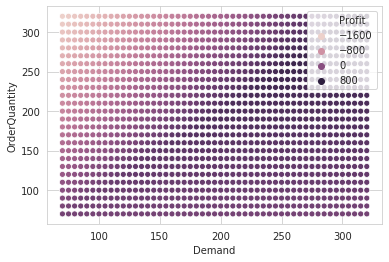

In [36]:
sns.set_style("whitegrid")

sns.scatterplot(x="Demand", y="OrderQuantity", hue="Profit", data=dtbl_1_df)

https://matplotlib.org/mpl_toolkits/mplot3d/tutorial.html#mplot3d-tutorial

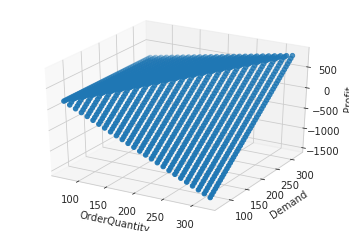

In [37]:
# Make the plot 
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(dtbl_1_df['OrderQuantity'], dtbl_1_df['Demand'], dtbl_1_df['Profit'], 
                cmap=plt.cm.viridis)

ax.set_xlabel('OrderQuantity')
ax.set_ylabel('Demand')
ax.set_zlabel('Profit')

plt.show()

Let's try 2-way using OO model. We can't use direct array passing approach because of ...

In [31]:
# This won't work unless the two arrays are the same size - can't broadcast.
# Also, even if same size, doesn't do all combinations, just aligned elements.
demand_range = np.arange(70, 321, 5)
# order_quantity_range = np.arange(70, 321, 10)
order_quantity_range = np.arange(70, 321, 5)

# Method 1: Set property equal to an array
model1.demand = demand_range
model1.order_quantity = order_quantity_range

model1.profit()

array([175. , 187.5, 200. , 212.5, 225. , 237.5, 250. , 262.5, 275. ,
       287.5, 300. , 312.5, 325. , 337.5, 350. , 362.5, 375. , 387.5,
       400. , 412.5, 425. , 437.5, 450. , 462.5, 475. , 487.5, 500. ,
       512.5, 525. , 537.5, 550. , 562.5, 575. , 587.5, 600. , 612.5,
       625. , 637.5, 650. , 662.5, 675. , 687.5, 700. , 712.5, 725. ,
       737.5, 750. , 762.5, 775. , 787.5, 800. ])

Feels a little like hyperparameter grid search in scikit learn. Can we borrow some of their patterns?

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV

https://scikit-learn.org/stable/modules/grid_search.html#grid-search

Example from User Guide shows passing in two different grids to explore as a list of dicts. Notice that each dict is like the setup for an Excel Data Table.

    param_grid = [
      {'C': [1, 10, 100, 1000], 'kernel': ['linear']},
      {'C': [1, 10, 100, 1000], 'gamma': [0.001, 0.0001], 'kernel': ['rbf']},
     ]
     
     
For example, the `GridSearchCV` takes and estimator object and a parameter grid object. The parameter grid is a dict or list of dicts in which the keys are the parameter names. SKLearn implements a `ParameterGrid` class. Looking at its source, the docstring contains the following example. Notice that the result of `ParameterGrid(param_grid)` is a list of dicts in which each dict contains a specific combination of the parameter values, i.e., it generates all the combos. The second example shows the value of accepting a list of dicts as `param_grid` to avoid ridiculous or nonsensical combinations (e.g. the linear kernal has no gamma param).

    Examples
    --------
    >>> from sklearn.model_selection import ParameterGrid
    >>> param_grid = {'a': [1, 2], 'b': [True, False]}
    >>> list(ParameterGrid(param_grid)) == (
    ...    [{'a': 1, 'b': True}, {'a': 1, 'b': False},
    ...     {'a': 2, 'b': True}, {'a': 2, 'b': False}])
    True
    >>> grid = [{'kernel': ['linear']}, {'kernel': ['rbf'], 'gamma': [1, 10]}]
    >>> list(ParameterGrid(grid)) == [{'kernel': 'linear'},
    ...                               {'kernel': 'rbf', 'gamma': 1},
    ...                               {'kernel': 'rbf', 'gamma': 10}]
    True
    >>> ParameterGrid(grid)[1] == {'kernel': 'rbf', 'gamma': 1}
    True

Clearly an end user modeler analagous to your basic Excel power user isn't going to write OO code to do a Data Table. The list comp approach based on a global function is much more likely. However, a relatively generic Data Table function could be implemented in an OO way and be quite reusable.

Let's explore the source code at

https://github.com/scikit-learn/scikit-learn/blob/b3ea3ed6a/sklearn/model_selection/_search.py#L971

to see how they manipulate the estimator and grid objects.

Hmm, we could use this class directly.

In [77]:
dt_param_ranges = {'demand': np.arange(70, 321, 25),
                'order_quantity': np.arange(70, 321, 50)}

In [79]:
dt_param_grid = list(ParameterGrid(dt_param_ranges))
dt_param_grid

[{'demand': 70, 'order_quantity': 70},
 {'demand': 70, 'order_quantity': 120},
 {'demand': 70, 'order_quantity': 170},
 {'demand': 70, 'order_quantity': 220},
 {'demand': 70, 'order_quantity': 270},
 {'demand': 70, 'order_quantity': 320},
 {'demand': 95, 'order_quantity': 70},
 {'demand': 95, 'order_quantity': 120},
 {'demand': 95, 'order_quantity': 170},
 {'demand': 95, 'order_quantity': 220},
 {'demand': 95, 'order_quantity': 270},
 {'demand': 95, 'order_quantity': 320},
 {'demand': 120, 'order_quantity': 70},
 {'demand': 120, 'order_quantity': 120},
 {'demand': 120, 'order_quantity': 170},
 {'demand': 120, 'order_quantity': 220},
 {'demand': 120, 'order_quantity': 270},
 {'demand': 120, 'order_quantity': 320},
 {'demand': 145, 'order_quantity': 70},
 {'demand': 145, 'order_quantity': 120},
 {'demand': 145, 'order_quantity': 170},
 {'demand': 145, 'order_quantity': 220},
 {'demand': 145, 'order_quantity': 270},
 {'demand': 145, 'order_quantity': 320},
 {'demand': 170, 'order_quantity

Great. Now, looking at source for `GridSearchCV`, we see that it uses a custom `clone` method to copy the base estimator without its x, y data. In our case, doing a simple deepcopy should suffice.

Of course, we could write our own stripped down ParameterGrid class just to demo zipping iterables or using itertools (?).

In [68]:
p1 = [1, 2, 3]
p2 = [100, 200]

In [43]:
import copy

In [82]:
model_clone = copy.deepcopy(model1)

In [83]:
model_clone == model1

False

In [84]:
print(model_clone)

{'unit_cost': 8.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 250, 'demand': 193}


Basic logic for an n-way Data Table for profit (hard coded to profit() function) that returns a DataFrame.

In [90]:
results = []
for params in dt_param_grid:
    model_clone.update(params)
    profit = model_clone.profit()
    result = copy.copy(params)
    result['profit'] = profit
    results.append(result)

results_df = pd.DataFrame(results)
    
print(results)

results_df.head()

[{'demand': 70, 'order_quantity': 70, 'profit': 105.0}, {'demand': 70, 'order_quantity': 120, 'profit': -270.0}, {'demand': 70, 'order_quantity': 170, 'profit': -645.0}, {'demand': 70, 'order_quantity': 220, 'profit': -1020.0}, {'demand': 70, 'order_quantity': 270, 'profit': -1395.0}, {'demand': 70, 'order_quantity': 320, 'profit': -1770.0}, {'demand': 95, 'order_quantity': 70, 'profit': 105.0}, {'demand': 95, 'order_quantity': 120, 'profit': -45.0}, {'demand': 95, 'order_quantity': 170, 'profit': -420.0}, {'demand': 95, 'order_quantity': 220, 'profit': -795.0}, {'demand': 95, 'order_quantity': 270, 'profit': -1170.0}, {'demand': 95, 'order_quantity': 320, 'profit': -1545.0}, {'demand': 120, 'order_quantity': 70, 'profit': 105.0}, {'demand': 120, 'order_quantity': 120, 'profit': 180.0}, {'demand': 120, 'order_quantity': 170, 'profit': -195.0}, {'demand': 120, 'order_quantity': 220, 'profit': -570.0}, {'demand': 120, 'order_quantity': 270, 'profit': -945.0}, {'demand': 120, 'order_quant

,demand,order_quantity,profit
0,70,70,105.0
1,70,120,-270.0
2,70,170,-645.0
3,70,220,-1020.0
4,70,270,-1395.0


Now, how to generalize to multiple outputs via indirect reference to object methods? I think `getattr` will do just fine.

In [99]:
results = []
outputs = ['profit', 'order_cost']

for params in dt_param_grid:
    model_clone.update(params)
    result = copy.copy(params)
    for output in outputs:
        out_val = getattr(model_clone, output)()
        result[output] = out_val
        results.append(result)

results_df = pd.DataFrame(results)
    
results_df.head()

,demand,order_quantity,profit,order_cost
0,70,70,105.0,595.0
1,70,70,105.0,595.0
2,70,120,-270.0,1020.0
3,70,120,-270.0,1020.0
4,70,170,-645.0,1445.0


In [96]:
print(model1)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


In [98]:
getattr(model1, 'profit')()

437.0

Well, that worked nicely. Now to functionize it.

In [100]:
def data_table(model, inputs, outputs):
    # TODO: Checking of inputs and outputs
    
    # Clone the model
    model_clone = copy.deepcopy(model)
    
    # Create parameter grid
    dt_param_grid = list(ParameterGrid(inputs))
    
    # Create the table
    results = []

    for params in dt_param_grid:
        model_clone.update(params)
        result = copy.copy(params)
        for output in outputs:
            out_val = getattr(model_clone, output)()
            result[output] = out_val
            results.append(result)

    results_df = pd.DataFrame(results)
    return results_df

In [101]:
dt_param_ranges = {'demand': np.arange(70, 321, 25),
                'order_quantity': np.arange(70, 321, 50)}

outputs = ['profit', 'order_cost']

# Create model
model2 = BookstoreModel(unit_cost=unit_cost, 
                        selling_price=selling_price,
                        unit_refund=unit_refund,
                        order_quantity=order_quantity,
                        demand=demand)
print(model2)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


In [102]:
data_table(model2, dt_param_ranges, outputs)

,demand,order_quantity,profit,order_cost
0,70,70,175.0,525.0
1,70,70,175.0,525.0
2,70,120,-150.0,900.0
3,70,120,-150.0,900.0
4,70,170,-475.0,1275.0
...,...,...,...,...
127,320,220,550.0,1650.0
128,320,270,675.0,2025.0
129,320,270,675.0,2025.0
130,320,320,800.0,2400.0


#### Goal Seek
Find break even demand for an order quantity of 250 and all other inputs at their base values.

Seems like using the `compute_profit` function is the way to go. Should be able to generalize to mulitple dimensions to create efficient frontier type outputs.

https://stackoverflow.com/questions/14261474/how-do-i-write-a-function-that-returns-another-function

https://docs.python.org/3/library/functools.html#partial-objects

https://stackoverflow.com/questions/37052253/choose-which-variable-to-solve-for-python-root-finding-using-fsolve

Actually, as you'll see below, this is quite a hornet's nest of meta-programming caused by the need to partially freeze the function for use with scipy.optimize but in which we don't know in advance which parameter will be the free one.

Perhaps this would be easier with the OO version. That turned out to be pretty easy to use for data tables. ... Well, not seeing obvious way to do this with OO especially since the function I want to goal seek calls other methods within the model class. Thinking I need to not use scipy.optimize and just write it myself.

https://github.com/patrickwalls/mathematical-python/ - has nice implementation of various root finding methods

In [ ]:
# clone the model
model = copy.deepcopy(model1)

obj_fn = 'profit'
target = 0
by_changing = 'demand'

In [ ]:
def bisection(f,a,b,N):
    '''Approximate solution of f(x)=0 on interval [a,b] by bisection method.

    Parameters
    ----------
    f : function
        The function for which we are trying to approximate a solution f(x)=0.
    a,b : numbers
        The interval in which to search for a solution. The function returns
        None if f(a)*f(b) >= 0 since a solution is not guaranteed.
    N : (positive) integer
        The number of iterations to implement.

    Returns
    -------
    x_N : number
        The midpoint of the Nth interval computed by the bisection method. The
        initial interval [a_0,b_0] is given by [a,b]. If f(m_n) == 0 for some
        midpoint m_n = (a_n + b_n)/2, then the function returns this solution.
        If all signs of values f(a_n), f(b_n) and f(m_n) are the same at any
        iteration, the bisection method fails and return None.

    Examples
    --------
    >>> f = lambda x: x**2 - x - 1
    >>> bisection(f,1,2,25)
    1.618033990263939
    >>> f = lambda x: (2*x - 1)*(x - 3)
    >>> bisection(f,0,1,10)
    0.5
    '''
    if f(a)*f(b) >= 0:
        print("Bisection method fails.")
        return None
    a_n = a
    b_n = b
    for n in range(1,N+1):
        m_n = (a_n + b_n)/2
        f_m_n = f(m_n)
        if f(a_n)*f_m_n < 0:
            a_n = a_n
            b_n = m_n
        elif f(b_n)*f_m_n < 0:
            a_n = m_n
            b_n = b_n
        elif f_m_n == 0:
            print("Found exact solution.")
            return m_n
        else:
            print("Bisection method fails.")
            return None
    return (a_n + b_n)/2

In [15]:
def goal_seek(model, obj_fn, target, by_changing, a, b, N=100):
    # TODO: Checking of inputs and outputs
    
    # Clone the model
    model_clone = copy.deepcopy(model)
    
    setattr(model_clone, by_changing, a)
    f_a_0 = getattr(model_clone, obj_fn)()
    setattr(model_clone, by_changing, b)
    f_b_0 = getattr(model_clone, obj_fn)()
    
    if (f_a_0 - target) * (f_b_0 - target) >= 0:
        print("Bisection method fails.")
        return None
    
    a_n = a
    b_n = b
    for n in range(1, N+1):
        m_n = (a_n + b_n)/2
        
        setattr(model_clone, by_changing, m_n)
        f_m_n = getattr(model_clone, obj_fn)()
        
        setattr(model_clone, by_changing, a_n)
        f_a_n = getattr(model_clone, obj_fn)()
        
        setattr(model_clone, by_changing, b_n)
        f_b_n = getattr(model_clone, obj_fn)()

        if (f_a_n - target) * (f_m_n - target) < 0:
            a_n = a_n
            b_n = m_n
        elif (f_b_n - target) * (f_m_n - target) < 0:
            a_n = m_n
            b_n = b_n
        elif f_m_n == target:
            print("Found exact solution.")
            return (m_n, n)
        else:
            print("Bisection method fails.")
            return None
    
    return ((a_n + b_n)/2, n)

In [16]:
print(model1)

{'unit_cost': 7.5, 'selling_price': 10.0, 'unit_refund': 2.5, 'order_quantity': 200, 'demand': 193}


In [17]:
model1.profit()

437.0

In [18]:
goal_seek(model1, 'profit', 0.0, 'demand', 100, 500, N=100)

Found exact solution.


(144.44444444444446, 51)

In [19]:
goal_seek(model1, 'profit', 0.0, 'selling_price', 1.0, 25.0, N=100)

Found exact solution.


(7.7357512953367875, 55)

In [ ]:
def goal_seek(obj_fn, fixed_args, target, by_changing):
    # See below for progress on this

In [93]:
unit_cost = 7.50
selling_price = 10.00
unit_refund = 2.50
order_quantity = 200

profit_demand = partial(compute_profit, unit_cost=unit_cost, selling_price=selling_price,
                   unit_refund=unit_refund, order_quantity=order_quantity)

In order to dynamically change the calling order on compute_profit, which we need to do depending on the variable that is being treated as the "changing cell", we have to wrap it in a lambda function that has its args in the desired order and then wrap that with partial. Now we should be able to use this version in scipy.optimize.

Got idea from:

https://stackoverflow.com/questions/51583924/python-typeerror-multiple-arguments-with-functools-partial

If we don't do this, we get the following behavior and we can't use it in scipy.optimize

In [106]:
# print(profit_demand(190))

'''
---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<ipython-input-106-0c7da8d554f8> in <module>
----> 1 print(profit_demand(190))

TypeError: compute_profit() got multiple values for argument 'unit_cost'
'''

TypeError: compute_profit() got multiple values for argument 'unit_cost'

In [97]:
profit_demand_2 = partial(lambda d, uc, sp, uf, oq: compute_profit(uc, sp, uf, oq, d),
                          uc=unit_cost, sp=selling_price, 
                          uf=unit_refund,
                          oq=order_quantity)

In [100]:
print(profit_demand_2(190))
print(profit_demand(demand=190))

410.0
410.0


In [82]:
profit_demand.args

()

In [83]:
profit_demand.keywords

{'unit_cost': 7.5,
 'selling_price': 10.0,
 'unit_refund': 2.5,
 'order_quantity': 200}

In [84]:
profit_demand.func

<function __main__.compute_profit(unit_cost=0, selling_price=0, unit_refund=0, order_quantity=0, demand=0)>

In [101]:
profit_demand(demand=demand)

array([-670., -625., -580., -535., -490., -445., -400., -355., -310.,
       -265., -220., -175., -130.,  -85.,  -40.,    5.,   50.,   95.,
        140.,  185.,  230.,  275.,  320.,  365.,  410.,  455.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.])

In [102]:
demand

array([ 70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130,
       135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195,
       200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255, 260,
       265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320])

In [103]:
profit_demand_2(demand)

array([-670., -625., -580., -535., -490., -445., -400., -355., -310.,
       -265., -220., -175., -130.,  -85.,  -40.,    5.,   50.,   95.,
        140.,  185.,  230.,  275.,  320.,  365.,  410.,  455.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,  500.,
        500.,  500.,  500.,  500.,  500.,  500.])

In [104]:
optimize.root_scalar(profit_demand_2, bracket=[0, 500])

      converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: 144.44444444444443

In [105]:
profit_demand_2?

Signature:      profit_demand_2(d, *, uc=7.5, sp=10.0, uf=2.5, oq=200)
Call signature: profit_demand_2(*args, **kwargs)
Type:           partial
String form:    functools.partial(<function <lambda> at 0x7fdbc3330820>, uc=7.5, sp=10.0, uf=2.5, oq=200)
File:           ~/anaconda3/envs/datasci/lib/python3.8/functools.py
Docstring:     
partial(func, *args, **keywords) - new function with partial application
of the given arguments and keywords.


Ok, so for a given variable for which to goal seek, we can write a partial lambda function to do the goal seek. Now, how can we create a function that creates the partial lambda function and that takes as input the base `compute_profit` function and the name of the keyword arg representing the decision variable?

https://stackoverflow.com/questions/14261474/how-do-i-write-a-function-that-returns-another-function

https://en.wikipedia.org/wiki/Currying

In [108]:
compute_profit?

Signature:
compute_profit(
    unit_cost=0,
    selling_price=0,
    unit_refund=0,
    order_quantity=0,
    demand=0,
)
Docstring: <no docstring>
File:      ~/Documents/teaching/adv_analytics/abm/notebooks/<ipython-input-70-83d0e8d07f8b>
Type:      function


In [110]:
dir(compute_profit)

['__annotations__',
 '__call__',
 '__class__',
 '__closure__',
 '__code__',
 '__defaults__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__get__',
 '__getattribute__',
 '__globals__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__kwdefaults__',
 '__le__',
 '__lt__',
 '__module__',
 '__name__',
 '__ne__',
 '__new__',
 '__qualname__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__']

In [117]:
compute_profit.__doc__

'\n    Compute profit in bookstore model\n    '

In [119]:
compute_profit.__dict__

{}

https://docs.python.org/3/library/inspect.html

https://treyhunner.com/2018/04/keyword-arguments-in-python/

In [120]:

import inspect

In [122]:
inspect.getdoc(compute_profit)

'Compute profit in bookstore model'

Signature objects are important and powerful for function programming.

https://www.python.org/dev/peps/pep-0362/

In [126]:
inspect.signature(compute_profit)

<Signature (unit_cost=0, selling_price=0, unit_refund=0, order_quantity=0, demand=0)>

In [127]:
dir(inspect.signature(compute_profit))

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '_bind',
 '_bound_arguments_cls',
 '_hash_basis',
 '_parameter_cls',
 '_parameters',
 '_return_annotation',
 'bind',
 'bind_partial',
 'empty',
 'from_builtin',
 'from_callable',
 'from_function',
 'parameters',
 'replace',
 'return_annotation']

In [128]:
sig = inspect.signature(compute_profit)
sig.parameters

mappingproxy({'unit_cost': <Parameter "unit_cost=0">,
              'selling_price': <Parameter "selling_price=0">,
              'unit_refund': <Parameter "unit_refund=0">,
              'order_quantity': <Parameter "order_quantity=0">,
              'demand': <Parameter "demand=0">})

In [138]:
sig.parameters['unit_cost']

<Parameter "unit_cost=0">

In [139]:
sig.parameters['unit_cost'].replace(default=100)

<Parameter "unit_cost=100">

In [129]:
dir(sig.parameters)

['__class__',
 '__contains__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'copy',
 'get',
 'items',
 'keys',
 'values']

In [137]:
for item in sig.parameters.items():
    print(item)
    print(item[1].name)
    print(item[1].default)

('unit_cost', <Parameter "unit_cost=0">)
unit_cost
0
('selling_price', <Parameter "selling_price=0">)
selling_price
0
('unit_refund', <Parameter "unit_refund=0">)
unit_refund
0
('order_quantity', <Parameter "order_quantity=0">)
order_quantity
0
('demand', <Parameter "demand=0">)
demand
0


In [123]:
inspect.getsource(compute_profit)

"def compute_profit(unit_cost=0, selling_price=0,\n                   unit_refund=0, order_quantity=0,\n                   demand=0):\n    '''\n    Compute profit in bookstore model\n    '''\n    order_cost = unit_cost * order_quantity\n    sales_revenue = np.minimum(order_quantity, demand) * selling_price\n    refund_revenue = np.maximum(0, order_quantity - demand)\n    profit = sales_revenue + refund_revenue - order_cost\n    return profit\n"

In [125]:
inspect.getsourcelines(compute_profit)[0]

['def compute_profit(unit_cost=0, selling_price=0,\n',
 '                   unit_refund=0, order_quantity=0,\n',
 '                   demand=0):\n',
 "    '''\n",
 '    Compute profit in bookstore model\n',
 "    '''\n",
 '    order_cost = unit_cost * order_quantity\n',
 '    sales_revenue = np.minimum(order_quantity, demand) * selling_price\n',
 '    refund_revenue = np.maximum(0, order_quantity - demand)\n',
 '    profit = sales_revenue + refund_revenue - order_cost\n',
 '    return profit\n']

In [121]:
inspect.getmembers(compute_profit)

[('__annotations__', {}),
 ('__call__',
  <method-wrapper '__call__' of function object at 0x7fdbc3112ee0>),
 ('__class__', function),
 ('__closure__', None),
 ('__code__',
  <code object compute_profit at 0x7fdbc2e85240, file "<ipython-input-114-4f3eeeda3a26>", line 1>),
 ('__defaults__', (0, 0, 0, 0, 0)),
 ('__delattr__',
  <method-wrapper '__delattr__' of function object at 0x7fdbc3112ee0>),
 ('__dict__', {}),
 ('__dir__', <function function.__dir__()>),
 ('__doc__', '\n    Compute profit in bookstore model\n    '),
 ('__eq__', <method-wrapper '__eq__' of function object at 0x7fdbc3112ee0>),
 ('__format__', <function function.__format__(format_spec, /)>),
 ('__ge__', <method-wrapper '__ge__' of function object at 0x7fdbc3112ee0>),
 ('__get__', <method-wrapper '__get__' of function object at 0x7fdbc3112ee0>),
 ('__getattribute__',
  <method-wrapper '__getattribute__' of function object at 0x7fdbc3112ee0>),
 ('__globals__',
  {'__name__': '__main__',
   '__doc__': 'Automatically creat

In [134]:
var = "demand"
# Create dictionary of key word args for all but var 
# The parameters attribute is an OrderedDict (see PEP 362)
fixed_inputs = {key:value for (key, value) in sig.parameters.items() if
                   key != var}
var_input = {key:value for (key, value) in sig.parameters.items() if
                   key == var}

In [135]:
print(fixed_inputs)
print(var_input)

{'unit_cost': <Parameter "unit_cost=0">, 'selling_price': <Parameter "selling_price=0">, 'unit_refund': <Parameter "unit_refund=0">, 'order_quantity': <Parameter "order_quantity=0">}
{'demand': <Parameter "demand=0">}


https://stackoverflow.com/questions/938429/scope-of-lambda-functions-and-their-parameters

In [144]:
fixed_inputs = {'unit_cost': 7.5,
 'selling_price': 10.0,
 'unit_refund': 2.5,
 'order_quantity': 200}

def make_partial_profit(fn, fixed_inputs, var_input):
     
    partial(lambda d, uc, sp, uf, oq: compute_profit(uc, sp, uf, oq, d),
                          **fixed_inputs)

In [97]:
profit_demand_2 = partial(lambda d, uc, sp, uf, oq: compute_profit(uc, sp, uf, oq, d),
                          uc=unit_cost, sp=selling_price, 
                          uf=unit_refund,
                          oq=order_quantity)

#### Monte-carlo sim

In [179]:
from scipy.stats import norm

In [180]:
demand_sim = np.random.normal(demand_mean, demand_sd, 1000)

In [182]:
rv_normal = norm(loc=demand_mean, scale=demand_sd)

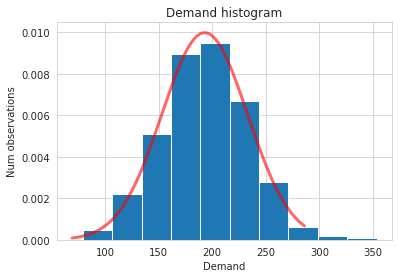

In [183]:
plt.title("Demand histogram")
plt.xlabel("Demand")
plt.ylabel("Density")
plt.hist(demand_sim, density=True);

x_normal = np.linspace(rv_normal.ppf(0.001),
                rv_normal.ppf(0.99), 500)

plt.plot(x_normal, rv_normal.pdf(x_normal),
       'r-', lw=3, alpha=0.6, label='Normal pdf');

In [153]:
profit_sim = pd.Series([(compute_profit(unit_cost, selling_price, 
                              unit_refund, order_quantity, d)) 
               for d in demand_sim])



In [155]:
profit_sim.describe()

count    1000.000000
mean      312.684293
std       234.945855
min      -740.404256
25%       159.693089
50%       424.138550
75%       500.000000
max       500.000000
dtype: float64

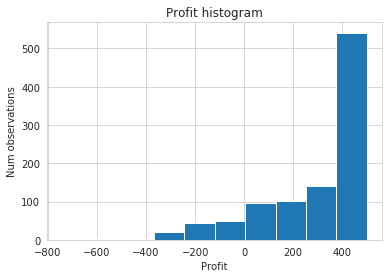

In [154]:
plt.title("Profit histogram")
plt.xlabel("Profit")
plt.ylabel("Num observations")
plt.hist(profit_sim, density=False);


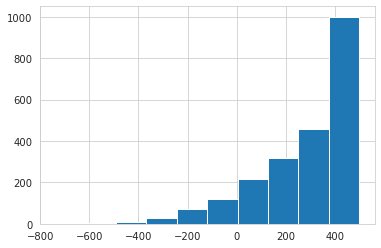

In [165]:
plt.hist(profit_sim, cumulative=True);

In [156]:
from scipy import stats

In [163]:
# Probability between -200, 200
print(stats.percentileofscore(profit_sim, 200))
print(stats.percentileofscore(profit_sim, -200))
print(stats.percentileofscore(profit_sim, 200) - stats.percentileofscore(profit_sim, -200))

28.0
4.2
23.8


In [170]:
cdf = stats.cumfreq(profit_sim)

In [171]:
x = cdf.lowerlimit + np.linspace(0, cdf.binsize*cdf.cumcount.size,
                                 cdf.cumcount.size)

(-809.3156038085306, 568.9113475688703)

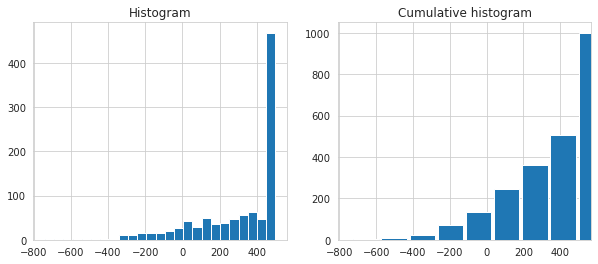

In [172]:
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)
ax1.hist(profit_sim, bins=25)
ax1.set_title('Histogram')
ax2.bar(x, cdf.cumcount, width=cdf.binsize)
ax2.set_title('Cumulative histogram')
ax2.set_xlim([x.min(), x.max()])

#### Sim table of profit vs order quantity

In [196]:
# Create data table (list of tuples)
order_quantity_range = np.arange(100, 400, 25)
sim_table_1 = [(oq, compute_profit(unit_cost, selling_price, unit_refund, oq, d)) 
for oq in order_quantity_range for d in demand_sim]

# Convert to dataframe

stbl_1_df = pd.DataFrame(sim_table_1, columns=['OrderQuantity', 'Profit'])

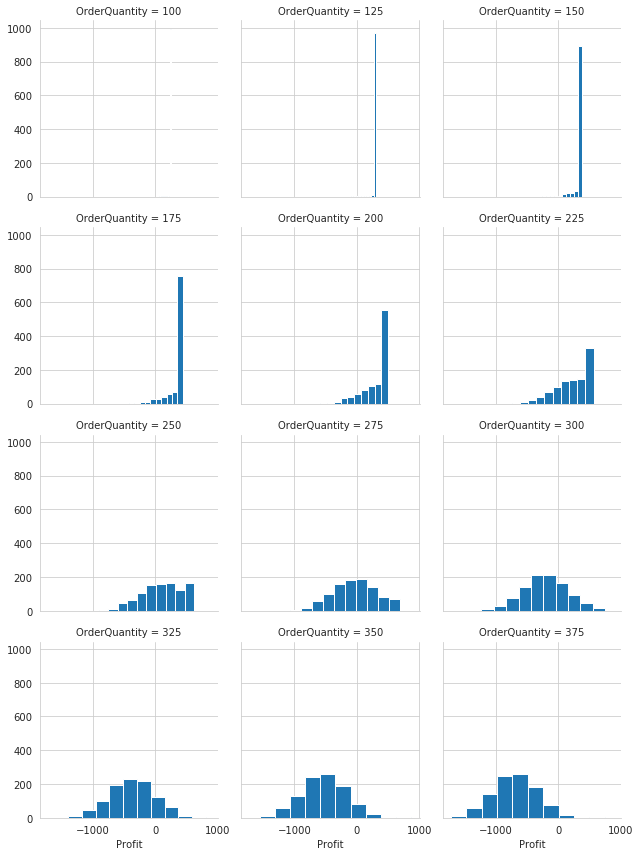

In [198]:
profit_histo_g = sns.FacetGrid(stbl_1_df, col="OrderQuantity", sharey=True, col_wrap=3)
profit_histo_g = profit_histo_g.map(plt.hist, "Profit")

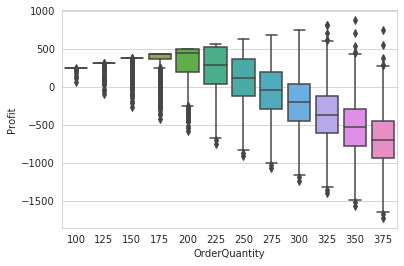

In [199]:
profit_box_g = sns.boxplot(x="OrderQuantity", y="Profit", data=stbl_1_df)